In [3]:
import torch
!pip install ultralytics
import torchvision.transforms as transforms
import ultralytics
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from torchvision import models
from torch import nn
import os
import glob
from PIL import Image
import cv2
import numpy as np

In [4]:
import ultralytics 

# Define paths
KITTI_PATH = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2"
YOLO_LABELS_PATH = "/kaggle/input/kitti-yolo-labels/labels"
DATA_PATH = "E/kaggle/working/"

# Create dataset directory structure
os.makedirs(f"{DATA_PATH}/images/train", exist_ok=True)
os.makedirs(f"{DATA_PATH}/images/val", exist_ok=True)
os.makedirs(f"{DATA_PATH}/labels/train", exist_ok=True)
os.makedirs(f"{DATA_PATH}/labels/val", exist_ok=True)

# Get image and label files
image_files = sorted([f for f in os.listdir(KITTI_PATH) if f.endswith(".png")])
label_files = sorted([f for f in os.listdir(YOLO_LABELS_PATH) if f.endswith(".txt")])

# Ensure matching images and labels
image_files = [f for f in image_files if f.replace(".png", ".txt") in label_files]

# Split into train and validation sets
train_images, val_images = train_test_split(image_files, test_size=0.2, random_state=42)

In [5]:
# Function to copy files (ensures both images and labels exist)
def copy_files(files, src_img, src_lbl, dst_img, dst_lbl):
    for file in files:
        img_src = os.path.join(src_img, file)
        lbl_src = os.path.join(src_lbl, file.replace(".png", ".txt"))
        img_dst = os.path.join(dst_img, file)
        lbl_dst = os.path.join(dst_lbl, file.replace(".png", ".txt"))
        
        if os.path.exists(lbl_src):  # Copy only if label exists
            shutil.copy(img_src, img_dst)
            shutil.copy(lbl_src, lbl_dst)

# Copy training and validation files
copy_files(train_images, KITTI_PATH, YOLO_LABELS_PATH, f"{DATA_PATH}/images/train", f"{DATA_PATH}/labels/train")
copy_files(val_images, KITTI_PATH, YOLO_LABELS_PATH, f"{DATA_PATH}/images/val", f"{DATA_PATH}/labels/val")

# ✅ Validation: Check for copied files
train_img_count = len(os.listdir(f"{DATA_PATH}/images/train"))
val_img_count = len(os.listdir(f"{DATA_PATH}/images/val"))

print(f"Training images: {train_img_count}")
print(f"Validation images: {val_img_count}")

# Raise an error if validation folder is empty
if val_img_count == 0:
    raise ValueError("Validation folder is empty. Check dataset splitting and file copying.")


Training images: 5984
Validation images: 1497


In [7]:
from ultralytics import YOLO

# Create dataset YAML file
dataset_yaml = f"""
path: {os.path.abspath(DATA_PATH)}
train: {os.path.abspath(DATA_PATH)}/images/train
val: {os.path.abspath(DATA_PATH)}/images/val
names:
  0: car
  1: pedestrian
  2: van
  3: Cyclist
  4: truck
  5: misc
  6: tram
  7: person_sitting
"""
with open(f"{DATA_PATH}/data.yaml", "w") as f:
    f.write(dataset_yaml)

# Train YOLOv8 model
model = YOLO("yolov8n.pt")
model.train(data=f"{DATA_PATH}/data.yaml", epochs=100, imgsz=640, batch=16 , val=True, verbose=True)

Ultralytics 8.3.106 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=E/kaggle/working//data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

train: Scanning /kaggle/working/E/kaggle/working/labels/train.cache... 5984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5984/5984 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/E/kaggle/working/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.88G      1.382      1.766      1.099        133        640: 100%|██████████| 374/374 [01:28<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


                   all       1497       8231      0.516      0.345      0.355      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.9G      1.258      1.172      1.069        159        640: 100%|██████████| 374/374 [01:27<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


                   all       1497       8231      0.494      0.415      0.424      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.9G      1.231      1.051       1.06        136        640: 100%|██████████| 374/374 [01:28<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.517        0.5      0.492      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.9G      1.197     0.9631      1.047        150        640: 100%|██████████| 374/374 [01:27<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


                   all       1497       8231      0.698      0.475      0.556      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.9G      1.165     0.8994      1.034        187        640: 100%|██████████| 374/374 [01:27<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


                   all       1497       8231      0.644      0.556      0.607      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.9G       1.14     0.8581      1.026        177        640: 100%|██████████| 374/374 [01:26<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]

                   all       1497       8231      0.658      0.515      0.577      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.9G      1.125      0.833      1.019        227        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


                   all       1497       8231      0.709      0.534      0.612      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.9G      1.105     0.8081      1.011        174        640: 100%|██████████| 374/374 [01:26<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.95it/s]


                   all       1497       8231       0.68      0.572       0.63      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.9G      1.095     0.7864      1.006        114        640: 100%|██████████| 374/374 [01:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       8231      0.739      0.566       0.68      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.9G      1.076     0.7634     0.9987        198        640: 100%|██████████| 374/374 [01:26<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


                   all       1497       8231       0.73      0.612      0.681      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.9G      1.062     0.7458     0.9949        208        640: 100%|██████████| 374/374 [01:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.42it/s]


                   all       1497       8231      0.805      0.592      0.701      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.9G       1.05     0.7314     0.9859        131        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


                   all       1497       8231      0.718      0.659       0.73      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.9G      1.041     0.7212     0.9863        215        640: 100%|██████████| 374/374 [01:23<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       8231      0.747      0.653      0.715      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.9G      1.036     0.7182     0.9868        131        640: 100%|██████████| 374/374 [01:22<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.10it/s]

                   all       1497       8231      0.764      0.641      0.731      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.9G      1.027     0.7067     0.9798        164        640: 100%|██████████| 374/374 [01:24<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


                   all       1497       8231      0.782      0.668       0.75      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.9G      1.015     0.6908     0.9778        134        640: 100%|██████████| 374/374 [01:23<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


                   all       1497       8231      0.771      0.664      0.741      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.9G      1.003     0.6788     0.9715        155        640: 100%|██████████| 374/374 [01:22<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


                   all       1497       8231      0.765      0.703      0.751      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.9G     0.9979      0.668     0.9696        137        640: 100%|██████████| 374/374 [01:24<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.17it/s]


                   all       1497       8231      0.754      0.696      0.767      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.9G     0.9928     0.6623     0.9716        151        640: 100%|██████████| 374/374 [01:24<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]

                   all       1497       8231      0.749      0.703      0.761      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.9G     0.9838     0.6589     0.9672        166        640: 100%|██████████| 374/374 [01:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]

                   all       1497       8231      0.808      0.676      0.764      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.02G     0.9748     0.6479     0.9621        193        640: 100%|██████████| 374/374 [01:24<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]

                   all       1497       8231      0.808      0.697      0.786      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.02G     0.9777     0.6469     0.9632        164        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


                   all       1497       8231      0.813      0.688      0.789      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.02G     0.9706       0.64     0.9598        185        640: 100%|██████████| 374/374 [01:23<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.93it/s]

                   all       1497       8231       0.76      0.724      0.791      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.02G     0.9672     0.6394     0.9595        134        640: 100%|██████████| 374/374 [01:27<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.837      0.709      0.797      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.02G     0.9549      0.632     0.9547        217        640: 100%|██████████| 374/374 [01:27<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.856      0.695      0.802      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.02G     0.9474     0.6216      0.952        137        640: 100%|██████████| 374/374 [01:27<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]


                   all       1497       8231      0.842      0.726      0.822      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.02G     0.9467      0.617      0.952        104        640: 100%|██████████| 374/374 [01:26<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.11it/s]


                   all       1497       8231      0.838      0.731      0.813      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.02G     0.9386     0.6116     0.9475        168        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


                   all       1497       8231      0.819      0.737      0.813      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.02G     0.9355     0.6078     0.9484        172        640: 100%|██████████| 374/374 [01:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]


                   all       1497       8231      0.832      0.754      0.831      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.02G     0.9278     0.6042     0.9453        168        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


                   all       1497       8231      0.809      0.754      0.829      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.02G     0.9228      0.596     0.9426        208        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.03it/s]


                   all       1497       8231      0.849       0.74      0.825      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.02G     0.9225     0.5991     0.9428        130        640: 100%|██████████| 374/374 [01:26<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.09it/s]


                   all       1497       8231      0.846      0.743      0.823      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.02G     0.9161     0.5886     0.9403        196        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]

                   all       1497       8231      0.808      0.761       0.83      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.02G     0.9166     0.5926     0.9406        143        640: 100%|██████████| 374/374 [01:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


                   all       1497       8231      0.825      0.767      0.831      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.02G     0.9062     0.5849     0.9376        133        640: 100%|██████████| 374/374 [01:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]


                   all       1497       8231      0.846      0.764      0.838      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.02G     0.9036     0.5803     0.9371        177        640: 100%|██████████| 374/374 [01:26<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


                   all       1497       8231      0.866      0.748      0.831      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.02G     0.8923     0.5717     0.9334        167        640: 100%|██████████| 374/374 [01:27<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.04it/s]


                   all       1497       8231      0.792      0.775      0.839      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.02G     0.8926     0.5707     0.9325        202        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]


                   all       1497       8231      0.842      0.757      0.839      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.02G     0.8879     0.5715      0.933        141        640: 100%|██████████| 374/374 [01:26<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.98it/s]


                   all       1497       8231      0.882      0.746      0.843      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.02G     0.8855      0.566     0.9318        137        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.874      0.777      0.852      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.02G     0.8734     0.5604     0.9283        169        640: 100%|██████████| 374/374 [01:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.848      0.767      0.848      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.02G     0.8753     0.5556     0.9265        189        640: 100%|██████████| 374/374 [01:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       8231      0.877      0.763      0.848      0.593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.02G     0.8781     0.5593     0.9255        178        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


                   all       1497       8231      0.876      0.786      0.863      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.02G     0.8668     0.5516     0.9246        210        640: 100%|██████████| 374/374 [01:26<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]


                   all       1497       8231      0.863      0.782      0.855      0.597

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.02G     0.8613      0.547     0.9216        141        640: 100%|██████████| 374/374 [01:24<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.23it/s]

                   all       1497       8231      0.874      0.775       0.86      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.02G     0.8616     0.5489     0.9235        146        640: 100%|██████████| 374/374 [01:22<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.35it/s]


                   all       1497       8231      0.875      0.784      0.863      0.609

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.02G     0.8575     0.5449     0.9224        148        640: 100%|██████████| 374/374 [01:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]

                   all       1497       8231       0.86      0.786      0.863      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.02G     0.8553     0.5409     0.9195        133        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.07it/s]

                   all       1497       8231      0.884      0.781      0.872       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.02G     0.8488     0.5358     0.9173        172        640: 100%|██████████| 374/374 [01:27<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


                   all       1497       8231      0.868      0.782      0.861      0.603

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.02G     0.8459     0.5355     0.9167        158        640: 100%|██████████| 374/374 [01:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


                   all       1497       8231      0.888       0.79      0.873      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.02G     0.8431     0.5294     0.9118        164        640: 100%|██████████| 374/374 [01:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


                   all       1497       8231      0.853      0.805      0.875      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.02G     0.8437     0.5309     0.9135        201        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.28it/s]


                   all       1497       8231      0.881      0.803      0.875      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.02G     0.8337     0.5244     0.9121        193        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


                   all       1497       8231      0.902      0.784       0.87      0.616

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.02G     0.8325     0.5223     0.9104        178        640: 100%|██████████| 374/374 [01:25<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


                   all       1497       8231      0.883      0.798      0.874      0.617

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.02G     0.8292     0.5231     0.9095        126        640: 100%|██████████| 374/374 [01:24<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.34it/s]


                   all       1497       8231      0.863      0.809      0.871      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.02G     0.8284     0.5218     0.9109        217        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]


                   all       1497       8231      0.889      0.782      0.872      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.02G      0.822     0.5124     0.9077        170        640: 100%|██████████| 374/374 [01:24<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


                   all       1497       8231      0.896      0.789      0.868      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.02G     0.8195     0.5133     0.9072        138        640: 100%|██████████| 374/374 [01:23<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       8231      0.897      0.782      0.877      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.02G     0.8169     0.5135     0.9083        190        640: 100%|██████████| 374/374 [01:22<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.29it/s]


                   all       1497       8231       0.89      0.787      0.872      0.625

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.02G     0.8143     0.5086     0.9061        138        640: 100%|██████████| 374/374 [01:22<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       8231       0.89      0.789      0.877      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.02G     0.8111      0.508     0.9069        188        640: 100%|██████████| 374/374 [01:24<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       8231      0.868      0.809      0.877      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.02G     0.8173     0.5107     0.9048        202        640: 100%|██████████| 374/374 [01:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.16it/s]


                   all       1497       8231      0.853      0.814      0.878      0.634

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.02G     0.8048     0.5033     0.9027        173        640: 100%|██████████| 374/374 [01:24<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.16it/s]


                   all       1497       8231      0.862      0.808      0.877      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.02G     0.8021     0.5006     0.9021        199        640: 100%|██████████| 374/374 [01:24<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.25it/s]


                   all       1497       8231      0.879      0.806      0.878      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.02G     0.8036     0.5026     0.9016        166        640: 100%|██████████| 374/374 [01:22<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.17it/s]

                   all       1497       8231      0.868      0.822      0.884      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.02G     0.8043     0.4998     0.9027        124        640: 100%|██████████| 374/374 [01:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.92it/s]


                   all       1497       8231      0.871      0.804       0.88      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.02G     0.7938     0.4948     0.8992        204        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.10it/s]


                   all       1497       8231      0.913      0.784      0.878      0.636

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.02G     0.7948      0.494     0.8988        193        640: 100%|██████████| 374/374 [01:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


                   all       1497       8231      0.883      0.808      0.887      0.643

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.02G     0.7876       0.49     0.8988        156        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]

                   all       1497       8231      0.891      0.794      0.888      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.02G     0.7868     0.4891     0.8964        165        640: 100%|██████████| 374/374 [01:26<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]

                   all       1497       8231       0.85      0.826      0.886      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.02G     0.7863     0.4878     0.8955        202        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.07it/s]

                   all       1497       8231      0.853      0.823      0.886      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.02G     0.7784     0.4852     0.8957        217        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.16it/s]


                   all       1497       8231      0.875      0.812      0.889      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.02G     0.7738     0.4824     0.8946        213        640: 100%|██████████| 374/374 [01:25<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


                   all       1497       8231      0.872      0.799      0.886      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.02G     0.7794     0.4848     0.8953        166        640: 100%|██████████| 374/374 [01:26<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.08it/s]


                   all       1497       8231      0.881      0.808      0.889      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.02G     0.7727     0.4813     0.8932        248        640: 100%|██████████| 374/374 [01:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.17it/s]


                   all       1497       8231      0.886      0.818      0.889      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.02G     0.7681     0.4774     0.8928        159        640: 100%|██████████| 374/374 [01:25<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.07it/s]


                   all       1497       8231      0.885      0.813      0.887      0.651

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.02G     0.7684     0.4785     0.8917        181        640: 100%|██████████| 374/374 [01:26<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]

                   all       1497       8231      0.861      0.825      0.888      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.02G     0.7661     0.4754     0.8922        188        640: 100%|██████████| 374/374 [01:26<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]

                   all       1497       8231      0.895      0.807      0.887      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.02G     0.7613     0.4726     0.8891        183        640: 100%|██████████| 374/374 [01:26<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.16it/s]


                   all       1497       8231      0.914      0.797      0.895      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.02G     0.7589     0.4691     0.8899        144        640: 100%|██████████| 374/374 [01:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


                   all       1497       8231      0.874      0.814       0.89      0.653

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.02G      0.756     0.4678     0.8892        151        640: 100%|██████████| 374/374 [01:24<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.02it/s]

                   all       1497       8231      0.908       0.79      0.893      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.02G     0.7594     0.4697     0.8897        178        640: 100%|██████████| 374/374 [01:25<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.05it/s]


                   all       1497       8231      0.902      0.802      0.895      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.02G     0.7478     0.4642     0.8862        147        640: 100%|██████████| 374/374 [01:22<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.23it/s]


                   all       1497       8231      0.901      0.806      0.893      0.655

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.02G     0.7519     0.4644     0.8851        169        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.25it/s]


                   all       1497       8231      0.893      0.804      0.892      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.02G     0.7436     0.4601     0.8844        155        640: 100%|██████████| 374/374 [01:24<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


                   all       1497       8231      0.873      0.818      0.892      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.02G     0.7466     0.4612     0.8858        145        640: 100%|██████████| 374/374 [01:24<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]

                   all       1497       8231      0.898        0.8      0.893      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.02G     0.7447     0.4619     0.8852        167        640: 100%|██████████| 374/374 [01:23<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]

                   all       1497       8231      0.908      0.802      0.895      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.02G      0.738     0.4575     0.8819        158        640: 100%|██████████| 374/374 [01:26<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]


                   all       1497       8231      0.926      0.797      0.898      0.668

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.02G     0.7344     0.4555     0.8816        222        640: 100%|██████████| 374/374 [01:25<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.19it/s]


                   all       1497       8231      0.905      0.804      0.895      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.02G     0.7346     0.4551     0.8819        169        640: 100%|██████████| 374/374 [01:26<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.13it/s]


                   all       1497       8231      0.904      0.811      0.897      0.666
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.02G      0.722     0.4338      0.875         94        640: 100%|██████████| 374/374 [01:25<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.10it/s]


                   all       1497       8231      0.885      0.814      0.891      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.02G     0.7031      0.424     0.8674        105        640: 100%|██████████| 374/374 [01:23<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.06it/s]


                   all       1497       8231      0.896      0.803      0.886      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.02G     0.6982     0.4198     0.8685         70        640: 100%|██████████| 374/374 [01:23<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.10it/s]

                   all       1497       8231      0.893      0.811       0.89      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.02G     0.6936     0.4184     0.8653        110        640: 100%|██████████| 374/374 [01:23<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.16it/s]

                   all       1497       8231      0.901      0.817      0.892      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.02G     0.6875     0.4165     0.8643         78        640: 100%|██████████| 374/374 [01:27<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.20it/s]


                   all       1497       8231        0.9      0.819       0.89       0.66

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.02G     0.6781     0.4099     0.8638         89        640: 100%|██████████| 374/374 [01:23<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.17it/s]

                   all       1497       8231      0.902      0.813      0.893      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.02G     0.6757     0.4071     0.8619         76        640: 100%|██████████| 374/374 [01:23<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.15it/s]


                   all       1497       8231      0.917      0.801      0.895      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.02G     0.6788     0.4085     0.8618         60        640: 100%|██████████| 374/374 [01:23<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.12it/s]

                   all       1497       8231      0.908       0.81      0.895      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.02G      0.678     0.4085     0.8599         62        640: 100%|██████████| 374/374 [01:21<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:10<00:00,  4.38it/s]


                   all       1497       8231      0.909      0.807      0.895      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.02G     0.6725      0.408     0.8609         88        640: 100%|██████████| 374/374 [01:22<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.17it/s]

                   all       1497       8231      0.912      0.804      0.894      0.663



100 epochs completed in 2.700 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.106 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:12<00:00,  3.83it/s]


                   all       1497       8231      0.927      0.796      0.898      0.669
                   car       1338       5889       0.96      0.889      0.966      0.797
            pedestrian        359        916      0.943      0.615      0.812      0.476
                   van        427        570      0.962       0.88      0.963       0.78
               Cyclist        222        308       0.95      0.734      0.864      0.587
                 truck        220        227      0.978      0.952      0.984      0.837
                  misc        156        187      0.863      0.807      0.888      0.671
                  tram         62         95       0.94      0.905      0.967       0.74
        person_sitting         20         39      0.818       0.59      0.739      0.462


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c06785cbc10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [8]:
metrics = model.val()

# Print precision, recall, mAP@50, and mAP@50-95
print(f"Precision: {metrics.box.mp:.4f}")  # Mean precision
print(f"Recall: {metrics.box.mr:.4f}")  # Mean recall
print(f"mAP@50: {metrics.box.map50:.4f}")  # Mean AP at IoU 0.5
print(f"mAP@50-95: {metrics.box.map:.4f}")  # Mean AP from 0.5 to 0.95

Ultralytics 8.3.106 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /kaggle/working/E/kaggle/working/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1497/1497 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 94/94 [00:13<00:00,  6.95it/s]


                   all       1497       8231      0.926      0.797      0.898      0.669
                   car       1338       5889       0.96      0.889      0.966      0.798
            pedestrian        359        916      0.943      0.615      0.812      0.479
                   van        427        570      0.964       0.88      0.963      0.781
               Cyclist        222        308      0.949      0.734      0.865      0.587
                 truck        220        227      0.978      0.952      0.984      0.839
                  misc        156        187      0.858      0.807      0.887      0.672
                  tram         62         95      0.938      0.905      0.967      0.742
        person_sitting         20         39      0.817       0.59      0.736      0.456


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train22
Precision: 0.9258
Recall: 0.7966
mAP@50: 0.8976
mAP@50-95: 0.6694



image 1/1 /kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000119.png: 224x640 3 cars, 1 van, 1 Cyclist, 8.3ms
Speed: 1.4ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)


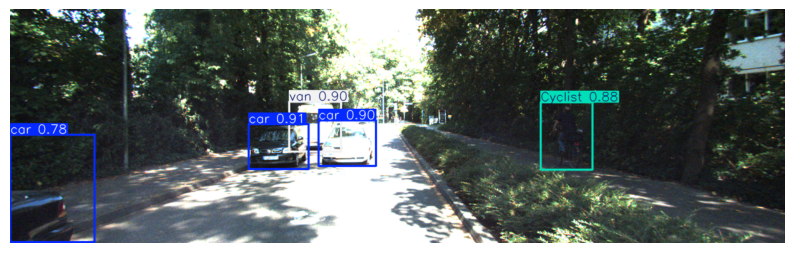

In [19]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load trained YOLOv8 model
model = YOLO("runs/detect/train/weights/best.pt")  # Change path if needed

# Load and run inference on the test image
image_path = "/kaggle/input/kitti-dataset/data_object_image_2/training/image_2/000119.png"  # Change to your image path
results = model(image_path)

# Display results
for r in results:
    img_with_boxes = r.plot()  # Draw detected objects on the image

# Convert BGR to RGB for correct display in Matplotlib
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.axis("off")  # Hide axes
plt.show()
